# Watchlist and (MOC) Area hits
### Ken Smith
This code gets a previously defined area on the sky with [MOC](https://cds-astro.github.io/mocpy/) (multi-order coverage maps), an [IVOA standard](https://ivoa.net/documents/MOC/) and grabs the ZTF objects that lie within that area that are also in a watchlist.  The code is in development, but for more information on converting (e.g.) Healpix maps of GW events to MOCs, feel free to get in touch.

We have defined the SDSS footprint within Lasair as https://lasair-ztf.lsst.ac.uk/area/2/ (area number 2).  The area number is needed for the SQL query later on.  Likewise, we also have a predefined watchlist of BLLacs https://lasair-ztf.lsst.ac.uk/watchlist/35/ (number 35).  In the current implementation, the watchlist number is also required later.

Demonstrates usage of:
* Area Hits
* Watchlist Hits
* /query/
* /objects/

This code demonstrates a query that can check a watchlist for ZTF hits that also overlap a previously defined area of the sky - e.g. GW 90% contour or SDSS area.  See https://lasair-ztf.lsst.ac.uk/area/ and https://lasair-ztf.lsst.ac.uk/watchlist/.

### Python (3 only) requirements - pip install
lasair, requests

In [21]:
!pip install lasair

DEPRECATION: Loading egg at /Users/roywilliams/Library/Python/3.11/lib/python/site-packages/pyglet-2.0.10-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Grab my Lasair API token
Get your Lasair token before you start. You can log into [Lasair](https://lasair.lsst.ac.uk) and click "My Profile"
at top right. Or use the command-line below.
```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
Make a file called settings.py with a line like: `API_TOKEN = '0123456789abcdefxxxxxxxxxxxxxxxxxxxxxxxx'`

In [22]:
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
from lasair import LasairError, lasair_client as lasair

### Make an SQL query
Note that the database is not very old - a few months.  (It's very much a prototype system, which may be destroyed and rebuilt at a moment's notice.)  Hence there will be no data older than 2021 in this system.

In [23]:
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
IF(objects.distpsnr1 < 2 AND objects.sgscore1 > 0.49, "PS1_star", "Not_PS1_star") score
"""

# watchlist 139 = 51,907 galaxies from French & Zabludoff 2018
# watchmap 2 = SDSS
tables = 'objects,sherlock_classifications,watchlists:139,areas:2'

# Lasair will attempt to join the tables internally without the need to specify
# explicit join conditions, unless you wish to restrict the results further.
# Hence conditions here are blank!
conditions = """
sherlock_classifications.classification in ('SN', 'NT', 'AGN')
"""


L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")
try:
    results = L.query(selected, tables, conditions, limit = 20)
except LasairError as e:
    print(e)


In [24]:
# Did we get anything - just crudely print out the results if so.
for row in results:
    try:
        print(row['objectId'],
              "%.5f" % row['ramean'],
              "%.5f" % row['decmean'],
              "%.5f" % row['mjdmin'],
              "%.5f" % row['mjdmax'],
              "%.2f" % row['magrmin'],
              "%.2f" % row['rmag'],
              row['classification'],
              row['score'])
    except:
        print(row['objectId'],
              row['ramean'],
              row['decmean'],
              row['mjdmin'],
              row['mjdmax'],
              row['magrmin'],
              row['rmag'],
              row['classification'],
              row['score'])

ZTF17aaaaanm 326.88713 44.86526 60230.20817 60242.20344 19.29 19.93 SN PS1_star
ZTF17aaaaatc 318.53395 45.06781 60091.39314 60091.39314 19.37 19.37 SN PS1_star
ZTF17aaaaatn 320.83886 46.23364 60050.45493 60077.41860 15.98 17.10 SN PS1_star
ZTF17aaaacjo 88.12308 14.44328 60231.44398 60257.39521 19.11 19.70 SN Not_PS1_star
ZTF17aaaadix 75.12347 44.35464 60235.40385 60253.38637 19.97 20.16 SN PS1_star
ZTF17aaaadqv 71.60800 44.11277 60137.47958 60137.48438 18.79 18.87 SN Not_PS1_star
ZTF17aaaafup 82.77620675000001 23.720652783333332 58522.16641200008 59227.20539350016 None None SN PS1_star
ZTF17aaaajfc 325.68412 47.15373 60156.33336 60156.40352 16.94 16.94 SN PS1_star
ZTF17aaaajuf 43.92101 -10.48975 58388.52328 59220.21404 17.30 19.16 NT Not_PS1_star
ZTF17aaaazuo 324.59756 50.32255 60226.20392 60254.11138 17.92 19.05 SN PS1_star
ZTF17aaaazvg 324.92071 45.64401 60232.21807 60254.15781 19.83 19.87 SN PS1_star
ZTF17aaaazvv 321.35433 46.85130 60228.17568 60257.15630 18.39 18.39 SN PS1_star
ZTF

### Grab the lightcurves using the objects API

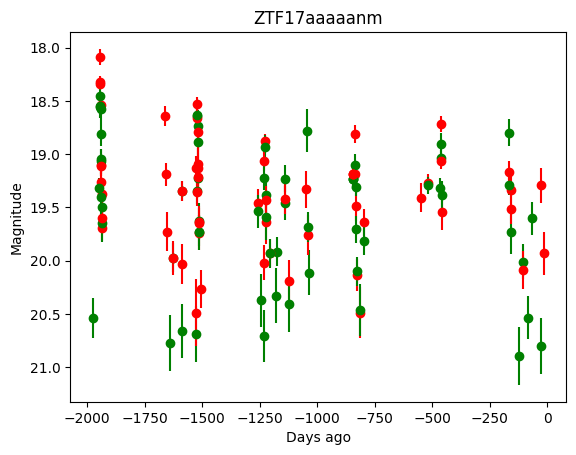

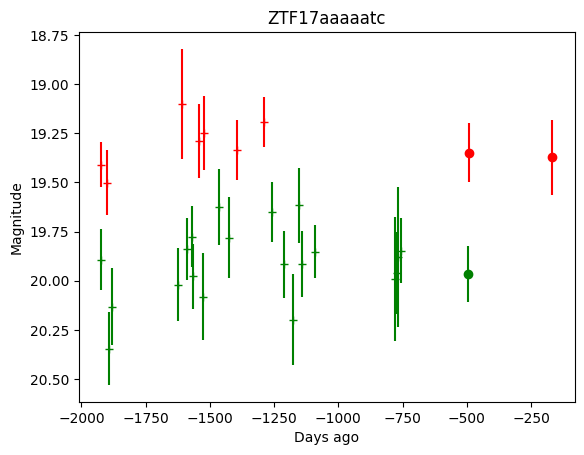

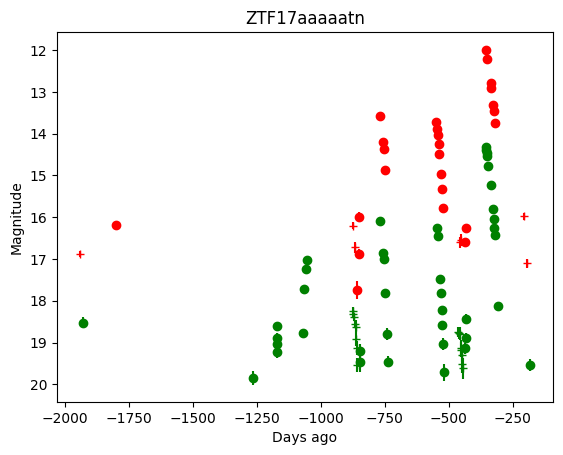

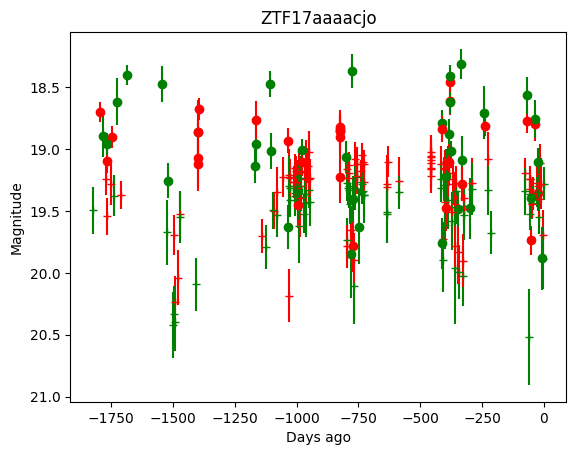

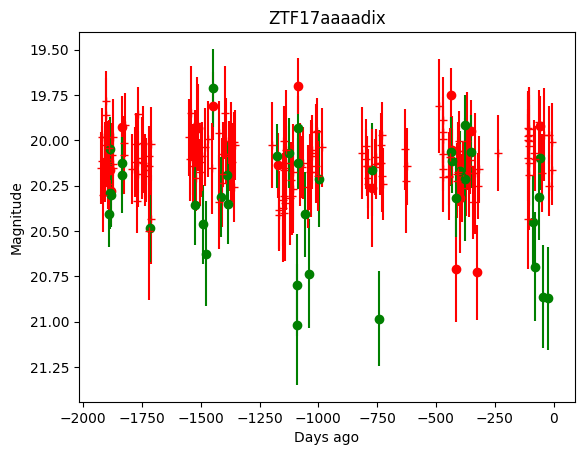

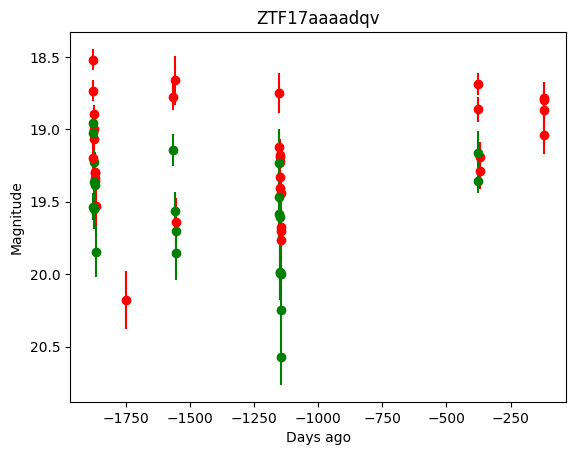

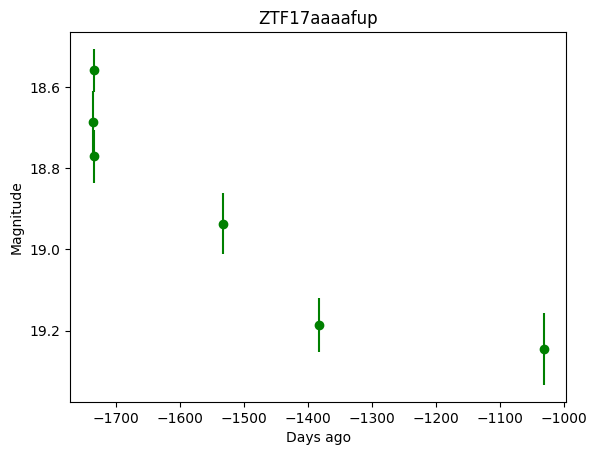

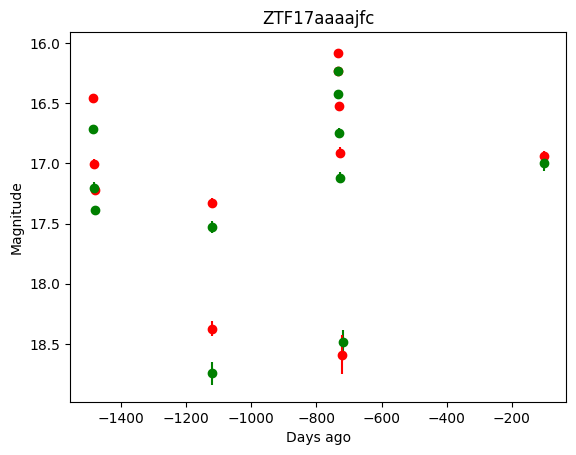

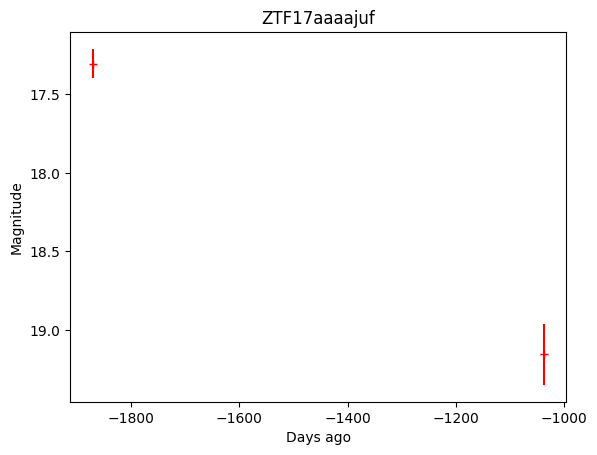

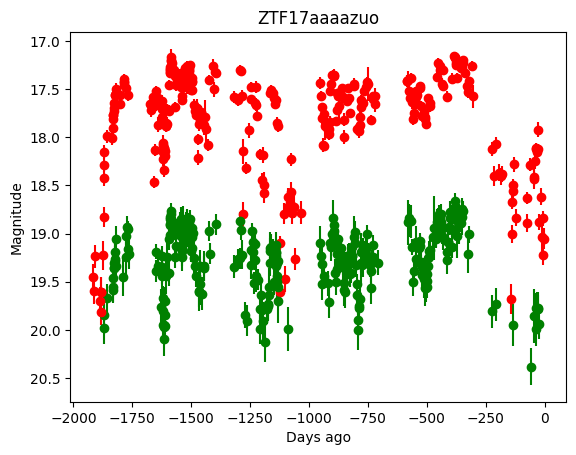

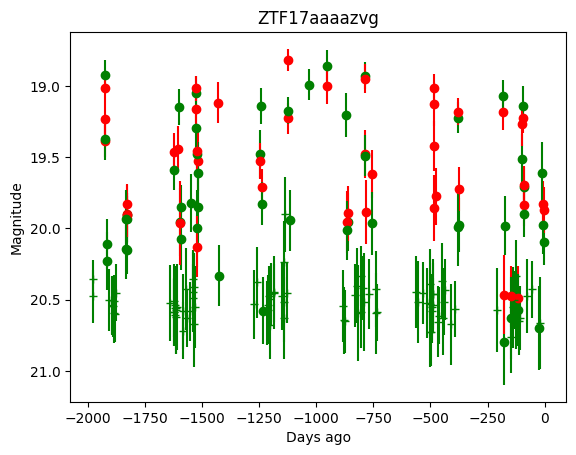

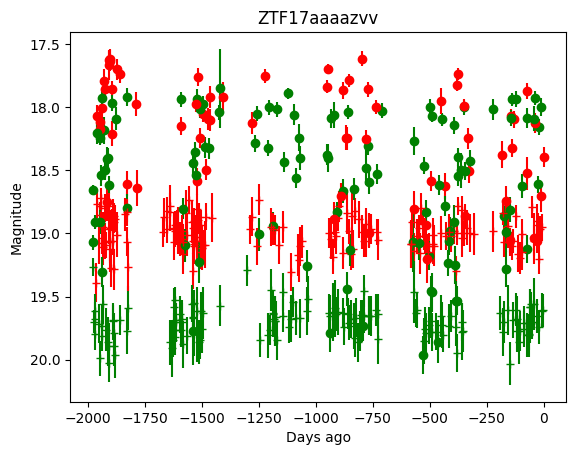

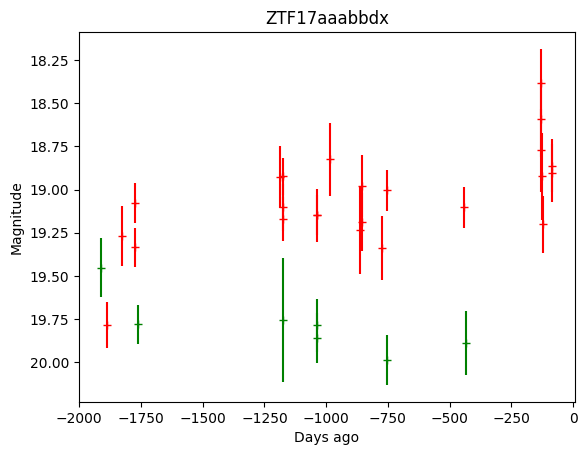

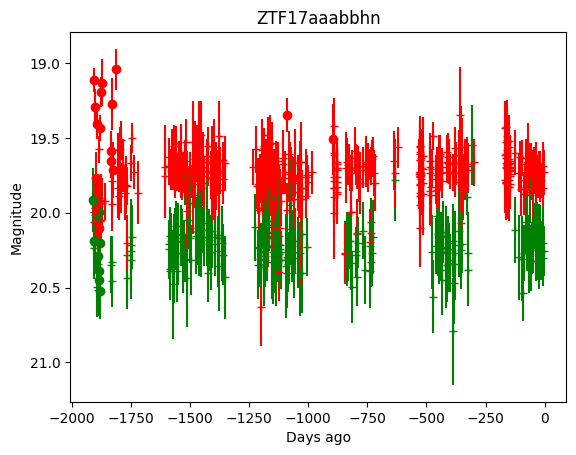

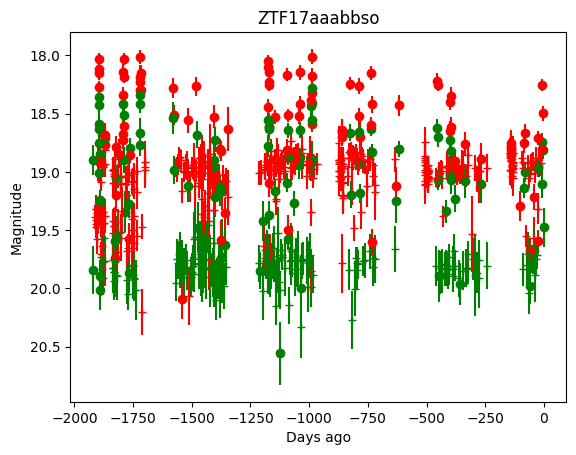

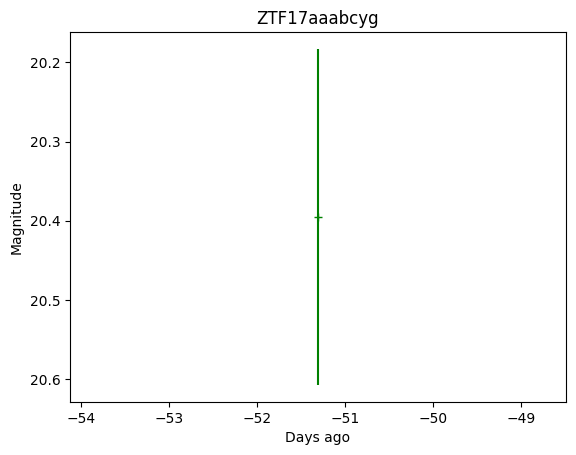

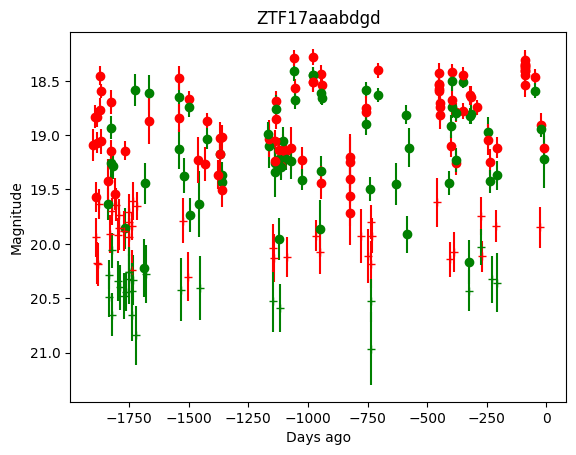

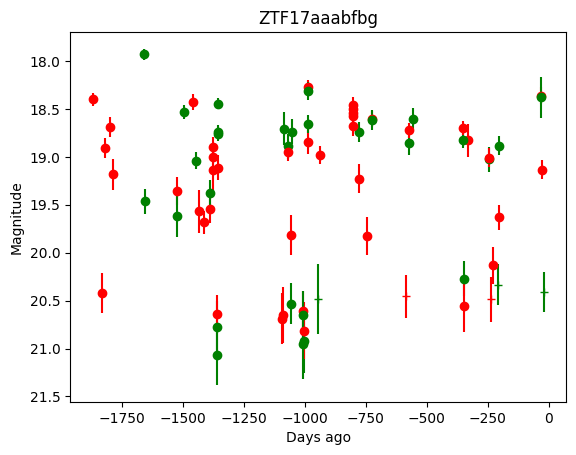

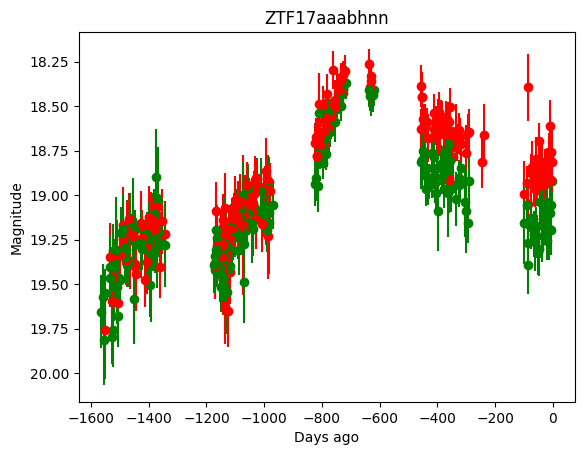

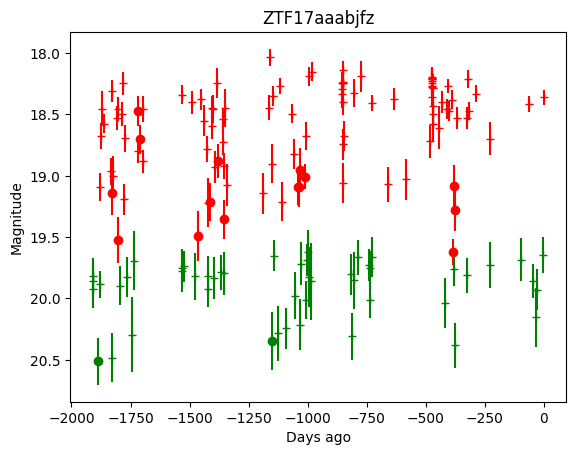

In [25]:
objectList = [row['objectId'] for row in results]
response = L.objects(objectList)

# create an dictionary of lightcurves

lcsDict = {}
for obj in response:
    lcsDict[obj['objectId']] = {'candidates': obj['candidates']}

cols = {1:'g',2:'r',3:'k'}

now = Time.now().jd

for obj in response:
        plt.figure()
        plt.subplot(111)
        for i in lcsDict[obj['objectId']]['candidates']:
            if 'isdiffpos' in i:
                if i['isdiffpos']=='t':
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
                else:
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='+',color=cols[i['fid']])

        plt.gca().invert_yaxis()
        plt.ylabel('Magnitude')
        plt.xlabel('Days ago')
        plt.title(obj['objectId'])
